# Inpainting

Projet ARF - 2017/2018

In [16]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Préambule : régression linéaire, régression ridge et LASSO

![./images/Q1.1.png](attachment:Q1.1.png)

Protocole expérimental pour comparer les trois algos dans le contexte de la classif plug-in:
 - regression linéaire
 - régression ridge
 - algo LASSO

### Experimentation

Nous allons tester avec le meme jeu d'entrainement et de test les trois algorithmes dans le contexte de la classifications plug-in.
Nous testerons avec différents paramètres pour voir comment évolue les résultats ainsi que le nombre de caractéristiques non nulles.

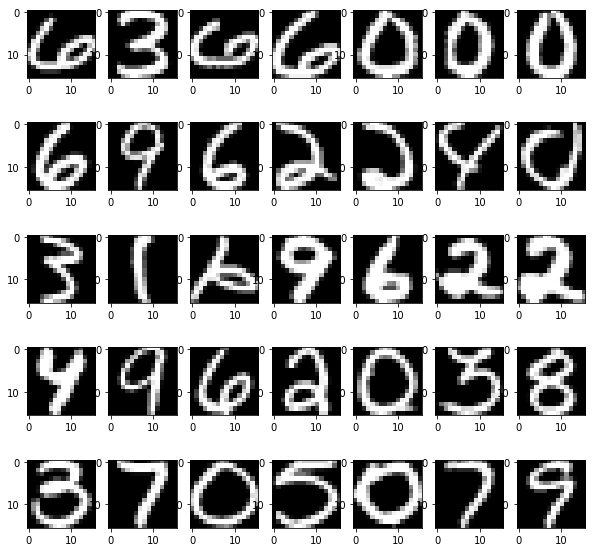

In [27]:
from tools import load_usps, show_sample_usps, filter_values, show_usps

training_setx, training_sety = load_usps("USPS_train.txt")
test_setx, test_sety = load_usps("USPS_test.txt")  

show_sample_usps(test_setx)

In [21]:
def plugin(fct, datax, datay):
    return 1 - np.sum(np.sign(fct.predict(datax)) - datay != 0) / datay.size

In [4]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression(normalize=True).fit(trainx, trainy)

print("Training set score: {:.2f}".format(lr.score(trainx, trainy)))
print("Test set score: {:.2f}\n".format(lr.score(testx, testy)))

print("Training set score: {:.2f}".format(plugin(lr, trainx, trainy)))
print("Test set score: {:.2f}".format(plugin(lr, testx, testy)))

Training set score: 0.68
Test set score: 0.61

Training set score: 0.98
Test set score: 0.98


In [5]:
from sklearn.linear_model import Ridge, RidgeCV

#ridge = RidgeCV(alphas=[0.0001,0.1, 1.0, 10.0], normalize=True).fit(trainx, trainy)
ridge = Ridge(alpha=0, normalize=True).fit(trainx, trainy)

print("Training set score: {:.2f}".format(ridge.score(trainx, trainy)))
print("Test set score: {:.2f}\n".format(ridge.score(testx, testy)))

print("Training set score: {:.2f}".format(plugin(ridge, trainx, trainy)))
print("Test set score: {:.2f}".format(plugin(ridge, testx, testy)))

Training set score: 0.68
Test set score: 0.61

Training set score: 0.98
Test set score: 0.98


In [ ]:
ridge.alpha_

In [6]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.00001,normalize=True).fit(trainx, trainy)

print("Training set score: {:.2f}".format(lasso.score(trainx, trainy)))
print("Test set score: {:.2f}\n".format(lasso.score(testx, testy)))

print("Training set score: {:.2f}".format(plugin(lasso, trainx, trainy)))
print("Test set score: {:.2f}".format(plugin(lasso, testx, testy)))
print("Number of features used: {}".format(np.sum(lasso.coef_ != 0)))

Training set score: 0.68
Test set score: 0.62

Training set score: 0.98
Test set score: 0.98
Number of features used: 213


In [42]:
def plot_lasso(data):
    plt.figure()
    plt.title("Lasso - Norme")
    plt.plot([i[3] for i in data], [i[4] for i in data], 'g', label="Norme")
    plt.show()
    
    fig, ax1 = plt.subplots()
    ax1.plot([i[3] for i in data], [i[2] for i in data], label="Features")
    ax1.set_xlabel('alpha')
    ax1.set_ylabel('nb of features', color='b')
    #ax1.axis((-0.003,0.003,0,260))
    ax1.tick_params('y', colors='b')

    ax2 = ax1.twinx()
    ax2.plot([i[3] for i in data], [i[1] for i in data], 'r',label="train")
    ax2.plot([i[3] for i in data], [i[0] for i in data], 'g',label="test")
    ax2.set_ylabel('score', color='r')
    #ax2.axis((-0.003,0.003,0.8,1))
    ax2.tick_params('y', colors='r')
    plt.title('Lasso')
    plt.legend()

    fig.tight_layout()
    plt.show()

def plot_ridge(data):
    plt.figure()
    plt.title("Ridge - Norme")
    plt.plot([i[3] for i in data], [i[4] for i in data], 'g', label="Norme")
    plt.show()
    
    fig, ax1 = plt.subplots()
    ax1.plot([i[3] for i in data], [i[2] for i in data], label="Features")
    ax1.set_xlabel('alpha')
    ax1.set_ylabel('nb of features', color='b')
    #ax1.axis((-0.003,0.003,0,260))
    ax1.tick_params('y', colors='b')
    
    ax2 = ax1.twinx()
    ax2.plot([i[3] for i in data], [i[1] for i in data], 'r', label="train")
    ax2.plot([i[3] for i in data], [i[0] for i in data], 'g', label="test")
    ax2.set_ylabel('score')
    #ax1.axis((0,10,0.8,1))
    plt.title('Ridge')
    plt.legend()

    fig.tight_layout()
    plt.show()

coef_threshold = 0.01
def predictFromModel(model, alpha, datax, datay, datatestx, datatesty):
    trainedModel = model(alpha=alpha, normalize=True).fit(datax, datay)
    return [plugin(trainedModel, datax, datay), \
           plugin(trainedModel, datatestx, datatesty), \
           np.sum(np.abs(trainedModel.coef_) > coef_threshold), \
           alpha, \
           np.linalg.norm(trainedModel.coef_)]

def testNumber(number, one_versus_all=True):
    if one_versus_all:
        trainy = np.where(training_sety == number, 1, -1)
        testy = np.where(test_sety == number, 1, -1)
        trainx = training_setx
        testx =test_setx
    else: # one vs one
        trainx, trainy = filter_values(training_setx, training_sety, number[0],number[1])
        testx, testy = filter_values(test_setx, test_sety, number[0],number[1])
    
    print(number)
    
    lassoTest = [predictFromModel(Lasso, i, trainx, trainy, testx, testy) for i in np.arange(-0.003, 0.003, 0.001)]
    ridgeTest = [predictFromModel(Ridge, i, trainx, trainy, testx, testy) for i in np.arange(-5, 5, 0.5)]
    
    plot_ridge(ridgeTest)
    plot_lasso(lassoTest)
    

6


/Users/samutamminen/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:52: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/Users/samutamminen/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/samutamminen/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


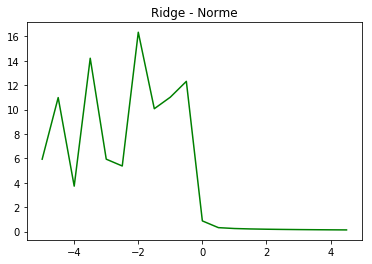

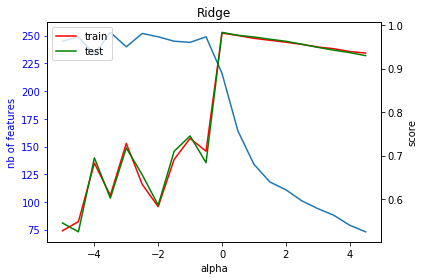

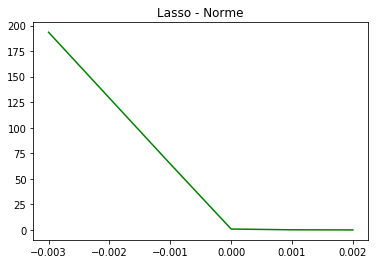

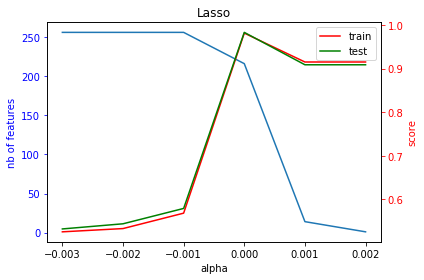

[0, 1]


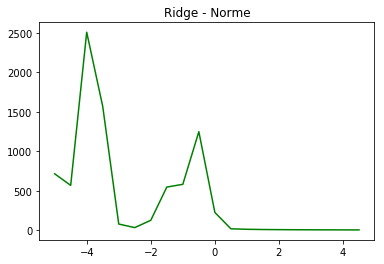

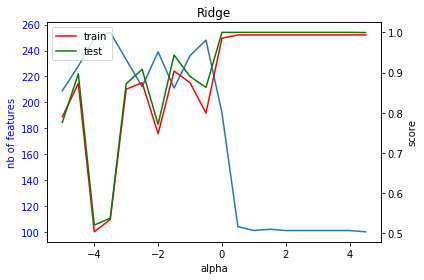

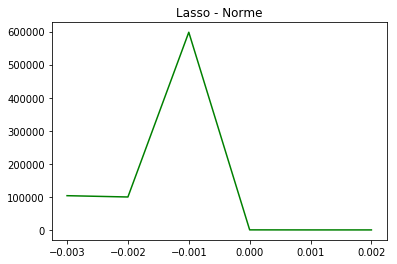

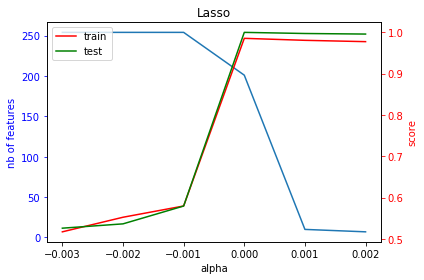

In [43]:
testNumber(6)
plt.figure()
testNumber([0,1], one_versus_all=False)

### Resultats

#### Regression Lineaire



#### Regression Ridge

On peut voir que la régression Ridge donne de moins bons résultats sur l'ensemble d'apprentissage que la régression linéaire mais est meilleur pour généraliser. Ceci est cohérent puisque qu'une régression linéaire tend a sur-apprendre, donnant ainsi de meilleurs performances sur le jeu d'apprentissage mais une moins bonne généralisation.

#### Algorithme du LASSO

La régularisation L1 (utilisé par l'algorithme du LASSO) a pour effet de mettre certain coefficient à zero. Ainsi certaine caractéristique sont totalement ignoré par le modèle. 

On peut le voir comme une sélection automatique des caractéristiques ce qui permet de révéler quelles sont celles qui sont les plus importantes pour le modèle. Un modèle avec moins de coéfficients est souvent plus facile a interpréter, a moins de chance de surapprendre et donc généralise mieux.

#### Comportement des poids
La norme approche zero trés vite aprés trouvé le alpha maximum (qui est souvent pres de zero). Le nombre des poids non nuls diminue, quand on augmente alpha.

## LASSO et Inpainting

<img src="./images/notations.png" style="float:left"/>

In [ ]:
# Longueur du patch (carré)
h = 5

In [ ]:
from matplotlib.colors import hsv_to_rgb, rgb_to_hsv
from sklearn.feature_extraction.image import extract_patches_2d

#  permet de lire une image et de la renvoyer sous forme d’un numpy.array
def read_im(fn):
    return np.array(plt.imread(fn))

# Affichage de l’image (et des pixels manquants)
def show_im(fn):
    plt.imshow(fn)

# retourne le patch centré en (i, j) et de longueur h d’une image im
def get_patch(i, j, h, im):
    window_shape = (h, h)
    B = extract_patches_2d(im, window_shape)
    return B[0][0]
    
im = read_im('images/ocean.png')
# show_im(read_im('images/ocean.png'))
patch = get_patch(0,0,2,im)
show_im(patch)